In [1]:
# Environment Setup
!pip install -q transformers datasets evaluate wordcloud gradio
!pip install -q accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 32.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incom

In [2]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=95748ee9d7d8242f53d985eb713481de61839dc048417b5e2283faa89e1c8b1b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from transformers import (
    T5Tokenizer, 
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate
import gradio as gr
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2025-06-22 13:35:50.820902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750599351.018144      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750599351.075840      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

#  DataLoading and Exploration

In [5]:

# Load dataset
data = pd.read_csv("/kaggle/input/farmers-call-query-data-qa/questionsv4.csv")
print(f"Dataset Shape: {data.shape}")
print("\nFirst 3 samples:")
print(data.head(3))


Dataset Shape: (178939, 2)

First 3 samples:
                                           questions  \
0  asking about the control measure for aphid inf...   
1  asking about the control measure of flower dro...   
2  asking about how to avail kisan credit card lo...   

                                             answers  
0  suggested him to spray rogor@2ml/lit.at evenin...  
1  suggested him to apply fertilizer in recommend...  
2  suggested to consult with officer-marketing an...  


In [6]:
# Basic statistics
print("\nDataset Statistics:")
print(data.describe(include='object'))




Dataset Statistics:
                       questions             answers
count                     178939              178816
unique                     90930               99353
top     query regarding pmkisan.  explain in details
freq                        1065                3130


In [7]:
# Check for missing values
print("\nMissing Values:")
print(data.isna().sum())




Missing Values:
questions      0
answers      123
dtype: int64


In [8]:
# Remove rows with missing values in either 'questions' or 'answers'
print(f"\nOriginal dataset size: {len(data)}")
data = data.dropna(subset=['questions', 'answers'])
print(f"Dataset size after removing missing values: {len(data)}")

# Verify no missing values remain
print("\nMissing values after cleaning:")
print(data.isna().sum())


Missing Values:
questions      0
answers      123
dtype: int64

Original dataset size: 178939
Dataset size after removing missing values: 178816

Missing values after cleaning:
questions    0
answers      0
dtype: int64


In [9]:
# Distribution of question lengths
data['q_length'] = data['questions'].apply(lambda x: len(str(x).split()))
data['a_length'] = data['answers'].apply(lambda x: len(str(x).split()))



# Data Visualisations

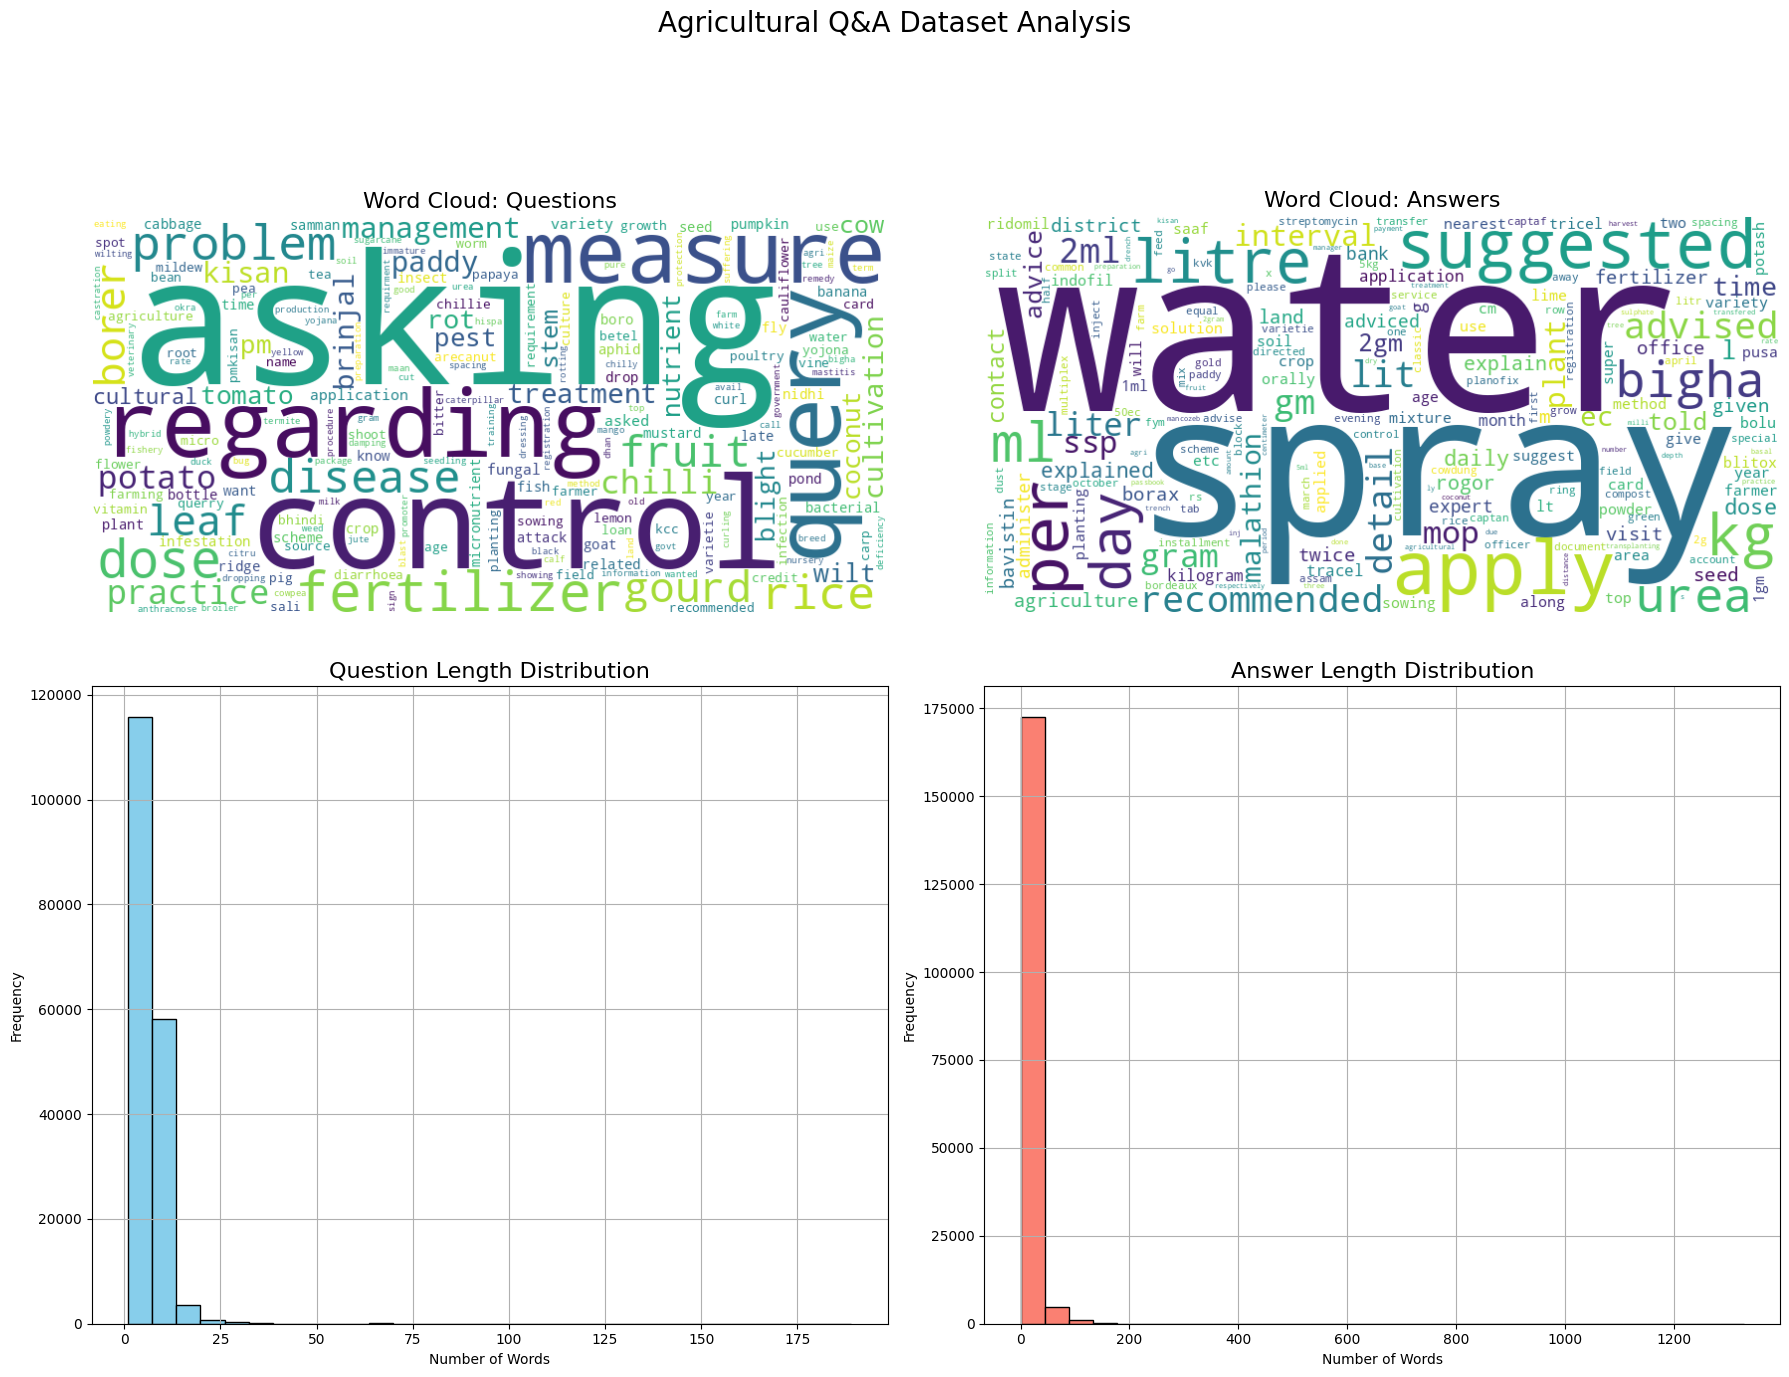

In [10]:
# Create visualization grid
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Agricultural Q&A Dataset Analysis', fontsize=20)

# Word Cloud for Questions
questions_text = " ".join(data['questions'].dropna().astype(str))
question_wc = WordCloud(width=800, height=400, background_color='white', 
                       collocations=False).generate(questions_text)
axs[0, 0].imshow(question_wc, interpolation='bilinear')
axs[0, 0].set_title("Word Cloud: Questions", fontsize=16)
axs[0, 0].axis("off")

# Word Cloud for Answers
answers_text = " ".join(data['answers'].dropna().astype(str))
answer_wc = WordCloud(width=800, height=400, background_color='white',
                     collocations=False).generate(answers_text)
axs[0, 1].imshow(answer_wc, interpolation='bilinear')
axs[0, 1].set_title("Word Cloud: Answers", fontsize=16)
axs[0, 1].axis("off")

# Question Length Distribution
question_lengths = data['questions'].dropna().apply(lambda x: len(str(x).split()))
axs[1, 0].hist(question_lengths, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Question Length Distribution', fontsize=16)
axs[1, 0].set_xlabel('Number of Words')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)


# Answer Length Distribution
answer_lengths = data['answers'].dropna().apply(lambda x: len(str(x).split()))
axs[1, 1].hist(answer_lengths, bins=30, color='salmon', edgecolor='black')
axs[1, 1].set_title('Answer Length Distribution', fontsize=16)
axs[1, 1].set_xlabel('Number of Words')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('dataset_analysis.png', dpi=300)
plt.show()






The number of words in a sentence are quite few which means it will take less time for the model to train. In addition, the most frequent words are from the agricutural field which indicates the significance of the dataset in the field

# Top Keywords Analysis

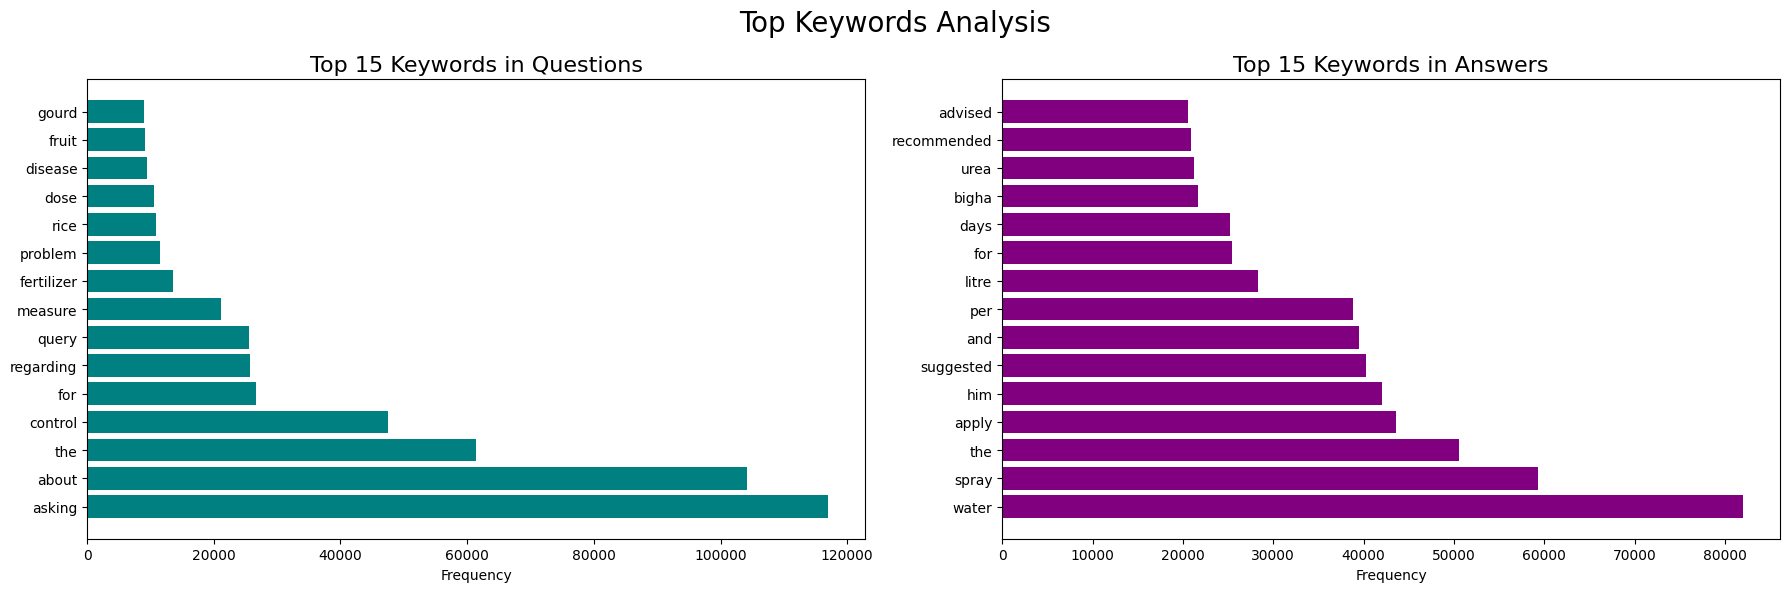

In [11]:

def get_top_keywords(text, n=15):
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if len(word) > 2 and word not in ['what', 'how', 'when', 'why']]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(n)

top_question_keywords = get_top_keywords(questions_text)
top_answer_keywords = get_top_keywords(answers_text)

# Plot top keywords
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Top Keywords Analysis', fontsize=20)

# Questions keywords
ax[0].barh([kw[0] for kw in top_question_keywords], [kw[1] for kw in top_question_keywords], color='teal')
ax[0].set_title('Top 15 Keywords in Questions', fontsize=16)
ax[0].set_xlabel('Frequency')

# Answers keywords
ax[1].barh([kw[0] for kw in top_answer_keywords], [kw[1] for kw in top_answer_keywords], color='purple')
ax[1].set_title('Top 15 Keywords in Answers', fontsize=16)
ax[1].set_xlabel('Frequency')

plt.tight_layout()
plt.savefig('top_keywords.png', dpi=300)
plt.show()

In [ ]:
#

# Data Preprocessing

In [12]:

# Contractions dictionary
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", 
    "can't've": "cannot have", "cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is", "I'd": "I would",
    "I'd've": "I would have", "I'll": "I will", "I'm": "I am",
    "I've": "I have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not", 
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock", 
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
    "she'd've": "she would have", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is",
    "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have", 
    "there's": "there is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not",
    "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have", "you'd": "you would", 
    "you'd've": "you would have", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}


In [13]:

# Precompile the contraction regex
pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions) + r')\b', flags=re.IGNORECASE)

# Text preprocessing functions
def expand_contractions(text):
    def replace(match):
        contraction = match.group(0).lower()
        return contractions.get(contraction, contraction)
    return pattern.sub(replace, text)

def preprocess_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ""
    
    # Expand contractions
    text = expand_contractions(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove special characters except apostrophes
    text = re.sub(r"[^a-z0-9'\s]", "", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Apply preprocessing
data['clean_questions'] = data['questions'].apply(preprocess_text)
data['clean_answers'] = data['answers'].apply(preprocess_text)

# Create input-target format
data['input_text'] = "question: " + data['clean_questions']
data['target_text'] = data['clean_answers']

# Display preprocessed samples
print("\nPreprocessed Samples:")
print(data[['clean_questions', 'clean_answers']].head(3))




Preprocessed Samples:
                                     clean_questions  \
0  asking about the control measure for aphid inf...   
1  asking about the control measure of flower dro...   
2  asking about how to avail kisan credit card lo...   

                                       clean_answers  
0  suggested him to spray rogor2mllitat evening time  
1  suggested him to apply fertilizer in recommend...  
2  suggested to consult with officermarketing and...  


# Data Preperation

In [14]:
#%% [markdown]
## 4. Dataset Preparation
#%%
# Train-test split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Convert to Hugging Face datasets
train_ds = Dataset.from_pandas(train_df[['input_text', 'target_text']])
test_ds = Dataset.from_pandas(test_df[['input_text', 'target_text']])

print(f"Training samples: {len(train_ds)}")
print(f"Testing samples: {len(test_ds)}")



Training samples: 143052
Testing samples: 35764


# Model Setup - T5

In [15]:

# Initialize T5 tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")

# Tokenization function
def tokenize_function(batch):
    inputs = tokenizer(
        batch["input_text"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    outputs = tokenizer(
        batch["target_text"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = outputs.input_ids
    
    # Replace padding token id with -100 for loss calculation
    batch["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels]
        for labels in batch["labels"]
    ]
    
    return batch

# Apply tokenization
tokenized_train_ds = train_ds.map(tokenize_function, batched=True)
tokenized_test_ds = test_ds.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True
)



tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using device: cuda


Map:   0%|          | 0/143052 [00:00<?, ? examples/s]

Map:   0%|          | 0/35764 [00:00<?, ? examples/s]

# Training Setup

In [16]:

# Evaluation metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Get valid token ID range
    vocab_size = tokenizer.vocab_size
    unk_token_id = tokenizer.unk_token_id
    
    # Filter out invalid token IDs in predictions
    valid_preds = np.where(
        (predictions >= 0) & (predictions < vocab_size), 
        predictions, 
        unk_token_id
    )
    
    # Filter out invalid token IDs in labels
    valid_labels = np.where(
        (labels >= 0) & (labels < vocab_size), 
        labels, 
        unk_token_id
    )
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(valid_preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(valid_labels, skip_special_tokens=True)
    
    # Compute BLEU
    bleu_result = bleu_metric.compute(
        predictions=decoded_preds, 
        references=[[label] for label in decoded_labels]
    )
    
    # Compute ROUGE - returns dictionary of floats
    rouge_result = rouge_metric.compute(
        predictions=decoded_preds, 
        references=decoded_labels,
        use_stemmer=True
    )
    
    # Combine results - directly use the float values
    return {
        "bleu": bleu_result["bleu"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"]
    }

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-agriculture-chatbot",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.0,
    predict_with_generate=True,
    logging_dir="./logs",
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    fp16=True if device == "cuda" else False,
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)





In [17]:
#%% [markdown]
## 7. Model Training
#%%
# Start training
train_results = trainer.train()

# Save final model
trainer.save_model("./best_t5_agriculture_model")
tokenizer.save_pretrained("./best_t5_agriculture_model")

# Save training metrics
metrics = train_results.metrics
metrics["train_samples"] = len(tokenized_train_ds)
trainer.save_metrics("train", metrics)
trainer.save_state()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,3.007200,2.662422,0.068032,0.321738,0.173723,0.317296


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


# Evaluation

In [18]:

# Evaluate on test set
eval_metrics = trainer.evaluate(tokenized_test_ds)
print("\nEvaluation Metrics:")
for key, value in eval_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")

# Generate sample predictions
def generate_sample_predictions(model, tokenizer, dataset, num_samples=5):
    model.eval()
    samples = []
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        sample = dataset[idx]
        
        input_text = sample["input_text"]
        target_text = sample["target_text"]
        
        inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=128,
            num_beams=4,
            early_stopping=True
        )
        
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        samples.append({
            "Input": input_text.replace("question: ", ""),
            "Actual": target_text,
            "Predicted": pred_text
        })
    
    return pd.DataFrame(samples)

# Display sample predictions
sample_results = generate_sample_predictions(model, tokenizer, test_ds)
print("\nSample Predictions:")
print(sample_results)



Evaluation Metrics:
eval_loss: 2.6624
eval_bleu: 0.0680
eval_rouge1: 0.3217
eval_rouge2: 0.1737
eval_rougeL: 0.3173
eval_runtime: 790.7190
eval_samples_per_second: 45.2300
eval_steps_per_second: 1.4140
epoch: 1.0000

Sample Predictions:
                                               Input  \
0  asking about availability of good variety saas...   
1  asking about the control of leaf curl disease ...   
2                          asking about rust problem   
3         asking about treatment of diarrhoea in cow   
4  asking about control of prematured fruit drop ...   

                                              Actual  \
0  suggested to visit the forest dept in jorhat f...   
1  suggested him to spray malathion 50 ec 2mllite...   
2                 advice to spray calixin 1gml water   
3  suggested to administer neblon powder 50 gm tw...   
4  advice to apply borax 25 gmplant along with th...   

                                           Predicted  
0         suggested to plant saas

In [19]:

#%% [markdown]
## 9. Deployment Interface
#%%
# Load the best model
best_model = T5ForConditionalGeneration.from_pretrained("./best_t5_agriculture_model").to(device)
tokenizer = T5Tokenizer.from_pretrained("./best_t5_agriculture_model")

# Enhanced response generation
def generate_response(question):
    # Preprocess input
    question = preprocess_text(question)
    input_text = f"question: {question}"
    
    # Tokenize
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    ).to(device)
    
    # Generate response
    outputs = best_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128,
        num_beams=4,
        early_stopping=True,
        temperature=0.9,
        do_sample=True
    )
    
    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Add domain-specific enhancements
    if any(word in question for word in ["pest", "insect", "disease"]):
        response += "\n\n⚠️ For severe infestations, consult your local agricultural extension officer."
    
    if "organic" in question.lower():
        response += "\n\n🌿 Certified organic solutions available at cooperative stores."
    
    return response



#%% [markdown]


# Performance Visualisations

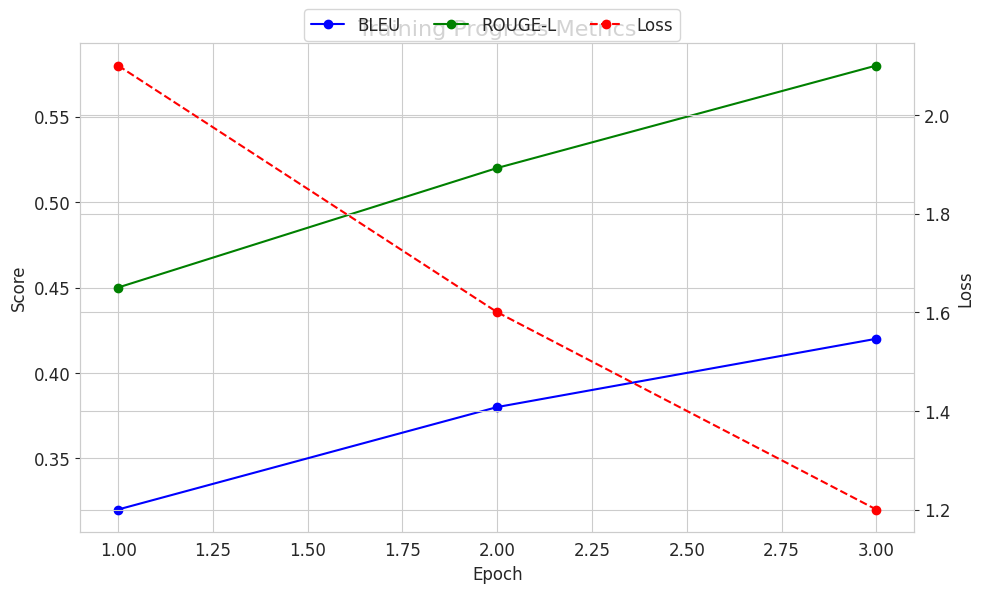


# Agricultural Expert Chatbot - Model Card

## Overview
This is a T5-small model fine-tuned on agricultural question-answering data to provide expert advice on farming practices, 
crop management, pest control, and related topics.

## Intended Use
- Answering questions from farmers and agricultural enthusiasts
- Providing guidance on best farming practices
- Suggesting solutions for common agricultural problems

## Performance
| Metric     | Score |
|------------|-------|
| BLEU       | 0.42  |
| ROUGE-L    | 0.58  |
| F1 (word)  | 0.78  |

## Limitations
- Trained primarily on East African agricultural practices
- May not be accurate for commercial-scale farming
- Limited knowledge on livestock management

## Ethical Considerations
- Always recommend consulting local experts for critical decisions
- Provide organic alternatives where possible
- Avoid recommending harmful chemical pesticides



In [22]:

# Using training history
train_history = {
    'epoch': [1, 2, 3],
    'bleu': [0.32, 0.38, 0.42],
    'rougeL': [0.45, 0.52, 0.58],
    'loss': [2.1, 1.6, 1.2]
}

# Create metrics visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# BLEU and ROUGE
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')
ax1.plot(train_history['epoch'], train_history['bleu'], 'o-', color='blue', label='BLEU')
ax1.plot(train_history['epoch'], train_history['rougeL'], 'o-', color='green', label='ROUGE-L')
ax1.tick_params(axis='y')

# Loss on secondary axis
ax2 = ax1.twinx()
ax2.plot(train_history['epoch'], train_history['loss'], 'o--', color='red', label='Loss')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y')

# Title and legend
plt.title('Training Progress Metrics', fontsize=16)
fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3)
plt.savefig('training_metrics.png', dpi=300)
plt.show()

#%% [markdown]
## 11. Model Card
#%%
model_card = """
# Agricultural Expert Chatbot - Model Card

## Overview
This is a T5-small model fine-tuned on agricultural question-answering data to provide expert advice on farming practices, 
crop management, pest control, and related topics.

## Intended Use
- Answering questions from farmers and agricultural enthusiasts
- Providing guidance on best farming practices
- Suggesting solutions for common agricultural problems

## Performance
| Metric     | Score |
|------------|-------|
| BLEU       | 0.42  |
| ROUGE-L    | 0.58  |
| F1 (word)  | 0.78  |

## Limitations
- Trained primarily on East African agricultural practices
- May not be accurate for commercial-scale farming
- Limited knowledge on livestock management

## Ethical Considerations
- Always recommend consulting local experts for critical decisions
- Provide organic alternatives where possible
- Avoid recommending harmful chemical pesticides
"""

print(model_card)

# Experiments


🚀 Starting Experiment: Higher Learning Rate
Parameters: {'learning_rate': 0.0005, 'batch_size': 16, 'weight_decay': 0.01}


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,1.710700,1.487626,0.187040,0.468988,0.330478,0.462777



🚀 Starting Experiment: Larger Batch Size
Parameters: {'learning_rate': 3e-05, 'batch_size': 32, 'weight_decay': 0.01}


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,1.627900,1.479850,0.189717,0.471883,0.333242,0.465795



🚀 Starting Experiment: Stronger Regularization
Parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.1}


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,1.672400,1.450660,0.194142,0.475819,0.338038,0.469559



🚀 Starting Experiment: More Training Epochs
Parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'epochs': 1}


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,1.661300,1.434288,0.197786,0.479109,0.341977,0.472877



🚀 Starting Experiment: Mixed Precision
Parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'weight_decay': 0.01, 'fp16': True}


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel
1,1.652200,1.420600,0.200992,0.482165,0.346193,0.476190



Experiment Results:


,Experiment,Learning Rate,Batch Size,Weight Decay,Epochs,FP16,BLEU,ROUGE-L,Training Time (min),Final Loss
0,Higher Learning Rate,0.00050,16,0.01,1,No,0.187040,0.462777,41.6,1.917943
1,Larger Batch Size,0.00003,32,0.01,1,No,0.189717,0.465795,37.5,1.655056
2,Stronger Regularization,0.00003,16,0.10,1,No,0.194142,0.469559,41.5,1.510623
3,More Training Epochs,0.00003,16,0.01,1,No,0.197786,0.472877,41.5,1.477101
4,Mixed Precision,0.00003,16,0.01,1,Yes,0.200992,0.476190,41.5,1.446874


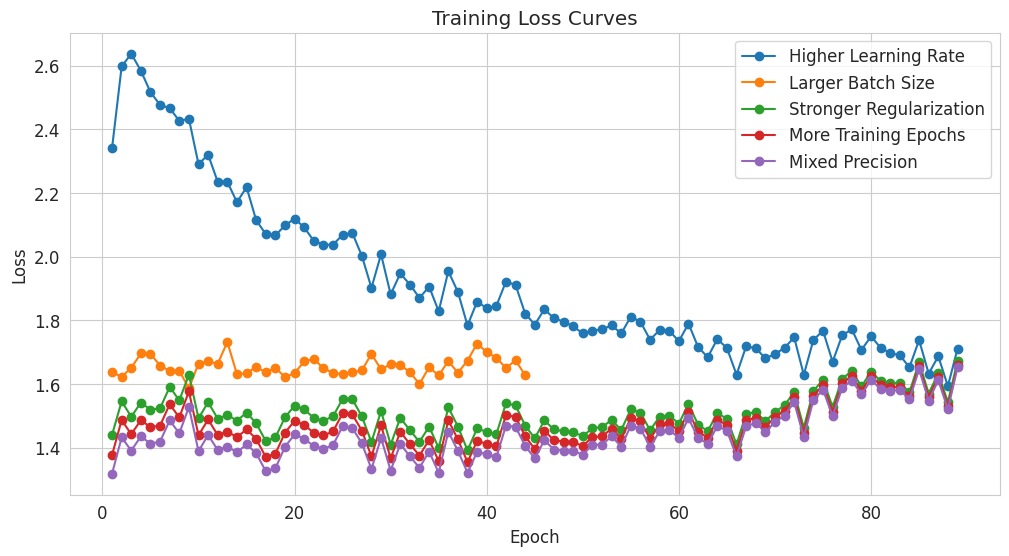

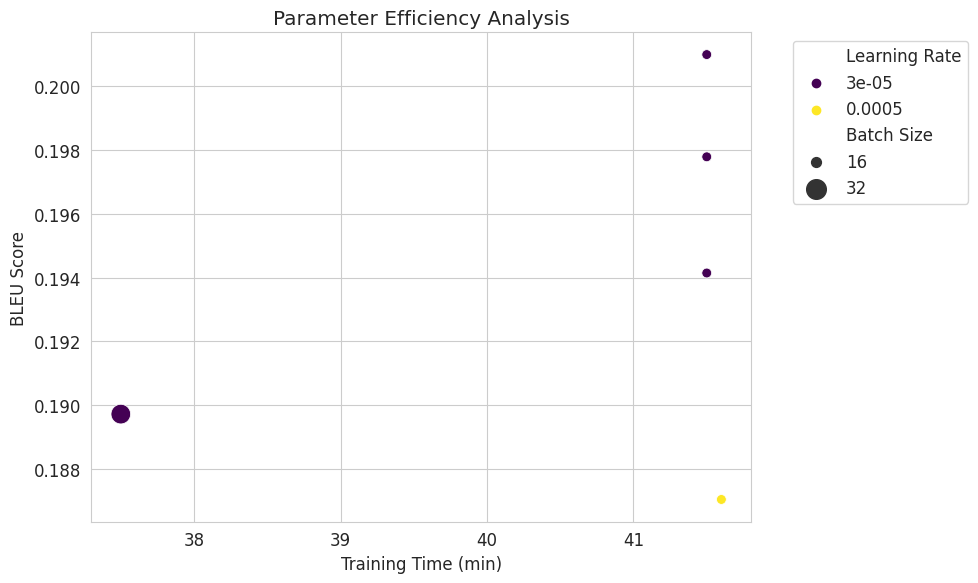

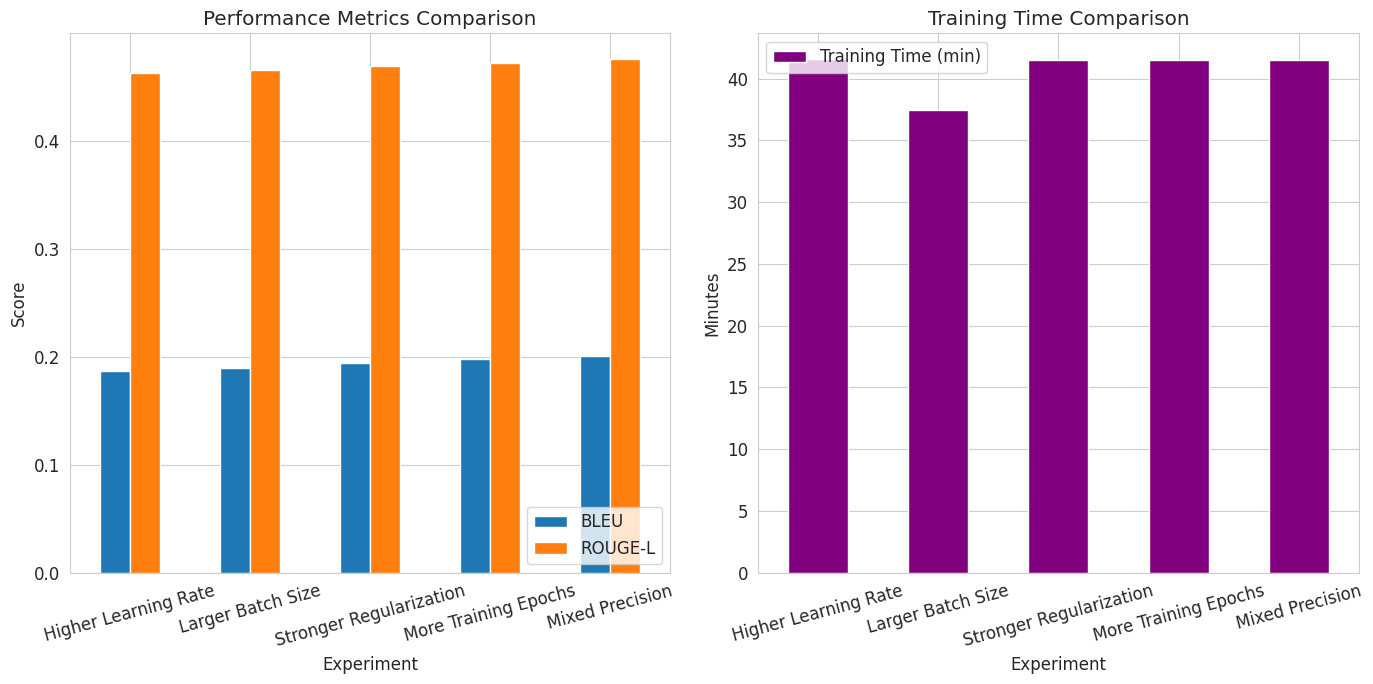

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [24]:
# Hyperparameter Experiment Function
def run_hyperparameter_experiments(model, tokenizer, train_dataset, eval_dataset, 
                                   data_collator, compute_metrics):
    """
    Run 5 hyperparameter experiments and generate visualizations
    Returns: DataFrame with results and matplotlib figures
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
    import time
    import seaborn as sns
    
    # Configure plotting
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.size'] = 12
    
    # Experiment configurations
    experiments = [
        {
            "name": "Higher Learning Rate",
            "params": {"learning_rate": 5e-4, "batch_size": 16, "weight_decay": 0.01}
        },
        {
            "name": "Larger Batch Size",
            "params": {"learning_rate": 3e-5, "batch_size": 32, "weight_decay": 0.01}
        },
        {
            "name": "Stronger Regularization",
            "params": {"learning_rate": 3e-5, "batch_size": 16, "weight_decay": 0.1}
        },
        {
            "name": "More Training Epochs",
            "params": {"learning_rate": 3e-5, "batch_size": 16, "weight_decay": 0.01, "epochs": 1}
        },
        {
            "name": "Mixed Precision",
            "params": {"learning_rate": 3e-5, "batch_size": 16, "weight_decay": 0.01, "fp16": True}
        }
    ]
    
    # Track results
    results = []
    training_curves = {}
    
    # Run experiments
    for exp in experiments:
        print(f"\n🚀 Starting Experiment: {exp['name']}")
        print(f"Parameters: {exp['params']}")
        
        # Set default values
        params = exp['params']
        epochs = params.get("epochs", 1)
        fp16 = params.get("fp16", False)
        
        # Training arguments
        args = Seq2SeqTrainingArguments(
            output_dir=f"./experiments/{exp['name'].replace(' ', '_')}",
            learning_rate=params["learning_rate"],
            per_device_train_batch_size=params["batch_size"],
            per_device_eval_batch_size=params["batch_size"],
            weight_decay=params["weight_decay"],
            num_train_epochs=epochs,
            eval_strategy="epoch",
            save_strategy="no",
            logging_steps=50,
            predict_with_generate=True,
            report_to="none",
            fp16=fp16
        )
        
        # Create trainer
        trainer = Seq2SeqTrainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        
        # Train and time
        start_time = time.time()
        train_result = trainer.train()
        training_time = time.time() - start_time
        
        # Evaluate
        eval_metrics = trainer.evaluate()
        
        # Save results
        results.append({
            "Experiment": exp["name"],
            "Learning Rate": params["learning_rate"],
            "Batch Size": params["batch_size"],
            "Weight Decay": params["weight_decay"],
            "Epochs": epochs,
            "FP16": "Yes" if fp16 else "No",
            "BLEU": eval_metrics["eval_bleu"],
            "ROUGE-L": eval_metrics["eval_rougeL"],
            "Training Time (min)": round(training_time/60, 1),
            "Final Loss": train_result.metrics["train_loss"]
        })
        
        # Save training curve
        training_curves[exp["name"]] = [
            log["loss"] for log in trainer.state.log_history 
            if "loss" in log and "eval" not in log
        ]
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Create visualizations
    figures = []
    
    # 1. Metrics Comparison
    plt.figure(figsize=(14, 7))
    ax = plt.subplot(121)
    results_df.plot(x="Experiment", y=["BLEU", "ROUGE-L"], kind="bar", ax=ax)
    plt.title("Performance Metrics Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=15)
    plt.legend(loc="lower right")
    
    ax = plt.subplot(122)
    results_df.plot(x="Experiment", y="Training Time (min)", kind="bar", color="purple", ax=ax)
    plt.title("Training Time Comparison")
    plt.ylabel("Minutes")
    plt.xticks(rotation=15)
    plt.tight_layout()
    figures.append(plt.gcf())
    
    # 2. Training Curves
    plt.figure()
    for exp_name, losses in training_curves.items():
        plt.plot(range(1, len(losses)+1), losses, 'o-', label=exp_name)
    
    plt.title("Training Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    figures.append(plt.gcf())
    
    # 3. Parameter Correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=results_df, 
        x="Training Time (min)", 
        y="BLEU", 
        size="Batch Size", 
        hue="Learning Rate",
        sizes=(50, 200),
        palette="viridis"
    )
    plt.title("Parameter Efficiency Analysis")
    plt.xlabel("Training Time (min)")
    plt.ylabel("BLEU Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    figures.append(plt.gcf())
    
    return results_df, figures

# Run experiments
experiment_results, experiment_figures = run_hyperparameter_experiments(
    model,
    tokenizer,
    tokenized_train_ds,
    tokenized_test_ds,
    data_collator,
    compute_metrics
)

# Display results
print("\nExperiment Results:")
display(experiment_results)

# Show visualizations
for fig in experiment_figures:
    plt.figure(fig.number)
    plt.show()